In [1]:
from bmtool.singlecell import Profiler, Passive, CurrentClamp, FI, ZAP, run_and_plot
from neuron import h
import neuron
from scipy.optimize import minimize

from dataclasses import dataclass
from typing import Dict, List, Tuple, Callable, Optional
import numpy as np

# Load the cell template
neuron.load_mechanisms("modfiles")
h.load_file("stdrun.hoc")
h.load_file("templates.hoc")  # Replace with your HOC file


--No graphics will be displayed.


1.0

In [2]:
@dataclass
class PassiveOptimizationResult:
    """Container for passive parameter optimization results"""
    optimal_params: Dict[str, float]  # Optimal parameter values
    achieved_metrics: Dict[str, float]  # Achieved metrics (e.g., R_in, Tau)
    target_metrics: Dict[str, float]  # Target metrics
    error: float  # Final error value
    optimization_path: List[Dict[str, float]]  # History of parameter values and errors


In [3]:
class PassiveOptimizer:
    def __init__(self, cell):
        """
        Initialize the passive properties optimizer.
        
        Parameters:
        -----------
        cell : Callable
            A callable that returns a new instance of the NEURON cell object.
        """
        self.cell = cell
        self.optimization_history = []
        self.param_scales = {}

    def _normalize_params(self, params: np.ndarray, param_names: List[str]) -> np.ndarray:
        """Normalize parameters to similar scales"""
        return np.array([params[i] / self.param_scales[name] for i, name in enumerate(param_names)])

    def _denormalize_params(self, normalized_params: np.ndarray, param_names: List[str]) -> np.ndarray:
        """Convert normalized parameters back to original scale"""
        return np.array([normalized_params[i] * self.param_scales[name] for i, name in enumerate(param_names)])

    def _calculate_metrics(self, cell_instance) -> Dict[str, float]:
        """Calculate passive properties (R_in and Tau) from the current simulation."""
        passive = Passive(cell_instance, inj_amp=-100, inj_delay=200, inj_dur=1000, tstop=1200, method='exp2')
        time, voltage = passive.execute()
        return {
            'R_in': passive.r_in,  # Input resistance (MΩ)
            'Tau': passive.tau  # Membrane time constant (ms)
        }

    def _default_cost_function(self, metrics: Dict[str, float], target_metrics: Dict[str, float]) -> float:
        """Default cost function that targets R_in and Tau."""
        error_r_in = (metrics['R_in'] - target_metrics['R_in']) ** 2
        error_tau = (metrics['Tau'] - target_metrics['Tau']) ** 2
        return error_r_in + error_tau

    def _objective_function(self, normalized_params: np.ndarray, param_names: List[str], cost_function: Callable, target_metrics: Dict[str, float], tolerance: Optional[Dict[str, float]] = None) -> float:
        """
        Calculate error using provided cost function.
        
        Parameters:
        -----------
        tolerance : Optional[Dict[str, float]]
            Tolerance for each metric. If the achieved metric is within the tolerance of the target, the optimization stops.
        """
        # Denormalize parameters
        params = self._denormalize_params(normalized_params, param_names)

        # Create a new instance of the cell
        cell_instance = self.cell()

        # Update passive properties
        for name, value in zip(param_names, params):
            if name == 'RM_scale':
                for sec in cell_instance.all:
                    sec.g_pas = 1.0 / (sec.g_pas * value)
            elif name == 'Cap_scale':
                for sec in cell_instance.all:
                    sec.cm *= value

        # Calculate metrics and error
        metrics = self._calculate_metrics(cell_instance)
        error = cost_function(metrics, target_metrics)

        # Store history with denormalized values
        history_entry = {
            'params': dict(zip(param_names, params)),
            'metrics': metrics,
            'error': error
        }
        self.optimization_history.append(history_entry)

        # Check if metrics are within tolerance
        if tolerance is not None:
            within_tolerance = all(
                abs(metrics[metric] - target_metrics[metric]) <= tolerance[metric]
                for metric in target_metrics
            )
            if within_tolerance:
                # Return a very small error to signal the optimizer to stop
                return 1e-10

        return error

    def optimize_parameters(self, target_metrics: Dict[str, float], param_bounds: Dict[str, Tuple[float, float]], cost_function: Optional[Callable] = None, method: str = 'L-BFGS-B', init_guess: str = 'middle_guess', tolerance: Optional[Dict[str, float]] = None) -> PassiveOptimizationResult:
        """
        Optimize passive properties to match target values.
        
        Parameters:
        -----------
        target_metrics : Dict[str, float]
            Target values for passive properties (e.g., {'R_in': 150.0, 'Tau': 20.0}).
        param_bounds : Dict[str, Tuple[float, float]]
            Bounds for each parameter to optimize (e.g., {'RM_scale': (0.1, 10.0), 'Cap_scale': (0.1, 10.0)}).
        cost_function : Optional[Callable]
            Custom cost function for optimization. If None, the default cost function is used.
        method : str, optional
            Optimization method to use (default: 'L-BFGS-B').
        init_guess : str, optional
            Method for initial parameter guess ('random' or 'middle_guess').
        tolerance : Optional[Dict[str, float]]
            Tolerance for each metric. If the achieved metric is within the tolerance of the target, the optimization stops.
            
        Returns:
        --------
        PassiveOptimizationResult
            Results of the optimization.
        """
        self.optimization_history = []

        param_names = list(param_bounds.keys())
        bounds = [param_bounds[name] for name in param_names]

        if cost_function is None:
            cost_function = self._default_cost_function

        # Calculate scaling factors
        self.param_scales = {
            name: max(abs(bounds[i][0]), abs(bounds[i][1]))
            for i, name in enumerate(param_names)
        }

        # Normalize bounds
        normalized_bounds = [
            (b[0] / self.param_scales[name], b[1] / self.param_scales[name])
            for name, b in zip(param_names, bounds)
        ]

        # Initial guess
        if init_guess == 'random':
            x0 = np.array([np.random.uniform(b[0], b[1]) for b in bounds])
        elif init_guess == 'middle_guess':
            x0 = [(b[0] + b[1]) / 2 for b in bounds]
        else:
            raise ValueError("Invalid init_guess method. Use 'random' or 'middle_guess'.")
        normalized_x0 = self._normalize_params(x0, param_names)

        # Run optimization
        result = minimize(
            self._objective_function,
            normalized_x0,
            args=(param_names, cost_function, target_metrics, tolerance),
            method=method,
            bounds=normalized_bounds
        )

        # Get final parameters and metrics
        final_params = dict(zip(param_names, self._denormalize_params(result.x, param_names)))
        final_metrics = self._calculate_metrics(self.cell())

        return PassiveOptimizationResult(
            optimal_params=final_params,
            achieved_metrics=final_metrics,
            target_metrics=target_metrics,
            error=result.fun,
            optimization_path=self.optimization_history
        )
    def plot_optimization_results(self, result: PassiveOptimizationResult):
        """
        Plot optimization results including convergence and final traces.
        
        Parameters:
        -----------
        result : PassiveOptimizationResult
            The result of the optimization.
        """
        # Ensure errors are properly shaped for plotting
        iterations = range(len(result.optimization_path))
        errors = np.array([float(h['error']) for h in result.optimization_path]).flatten()
        
        # Plot error convergence
        fig1, ax1 = plt.subplots(figsize=(8, 5))
        ax1.plot(iterations, errors, label='Error')
        ax1.set_xlabel('Iteration')
        ax1.set_ylabel('Error')
        ax1.set_title('Error Convergence')
        ax1.set_yscale('log')
        ax1.legend()
        plt.tight_layout()
        plt.show()
        
        # Plot parameter convergence
        param_names = list(result.optimal_params.keys())
        num_params = len(param_names)
        fig2, axs = plt.subplots(nrows=num_params, ncols=1, figsize=(8, 5 * num_params))
        
        if num_params == 1:
            axs = [axs]
            
        for ax, param in zip(axs, param_names):
            values = [float(h['params'][param]) for h in result.optimization_path]
            ax.plot(iterations, values, label=f'{param}')
            ax.set_xlabel('Iteration')
            ax.set_ylabel('Parameter Value')
            ax.set_title(f'Convergence of {param}')
            ax.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Print final results
        print("Optimization Results:")
        print(f"Final Error: {float(result.error):.2e}\n")
        print("Target Metrics:")
        for metric, value in result.target_metrics.items():
            achieved = result.achieved_metrics.get(metric)
            if achieved is not None:
                print(f"{metric}: {float(achieved):.3f} (target: {float(value):.3f})")
        
        print("\nOptimal Parameters:")
        for param, value in result.optimal_params.items():
            print(f"{param}: {float(value):.3f}")

In [4]:
# Create the cell (as a callable)
cell = h.CP_Cell

# Define target metrics
target_metrics = {'R_in': 91.98, 'Tau': 37.58}

# Define parameter bounds
param_bounds = {'Cap_scale': (0.1, 2.0)}

# Define tolerance for each metric
tolerance = {'R_in': 5.0, 'Tau': 2.0}  # Stop if R_in is within ±1.0 and Tau is within ±2.0 of the target

# Create the optimizer
optimizer = PassiveOptimizer(cell)

# Run the optimization
result = optimizer.optimize_parameters(target_metrics, param_bounds, tolerance=tolerance)

# Print the results
print("Optimization Results:")
print(f"Optimal Parameters: {result.optimal_params}")
print(f"Achieved Metrics: {result.achieved_metrics}")
print(f"Error: {result.error}")

Injection location: CP_Cell[0].soma[0](0.5)
Recording: CP_Cell[0].soma[0](0.5)._ref_v
Running simulation for passive properties...

V Rest: -66.45 (mV)
Resistance: 91.98 (MOhms)
Membrane time constant: 51.17 (ms)

V_rest Calculation: Voltage taken at time 200.0 (ms) is
-66.45 (mV)

R_in Calculation: dV/dI = (v_final-v_rest)/(i_final-i_start)
(-75.64 - (-66.45)) / (-0.1 - 0)
9.20 (mV) / 0.1 (nA) = 91.98 (MOhms)

Tau Calculation: Fit a double exponential curve to the membrane potential response
f(t) = a0 + a1*exp(-t/tau1) + a2*exp(-t/tau2)
Constrained by initial value: f(0) = a0 + a1 + a2 = v_rest
Fit parameters: (a0, a1, a2, tau1, tau2) = (-75.64, -1.20, 10.40, 51.17, 13.56)
Membrane time constant is determined from the slowest exponential term: 51.17 (ms)

Sag potential: v_sag = v_peak - v_final = -0.28 (mV)
Normalized sag potential: v_sag / (v_peak - v_rest) = 0.030

Injection location: CP_Cell[1].soma[0](0.5)
Recording: CP_Cell[1].soma[0](0.5)._ref_v
Running simulation for passive pr

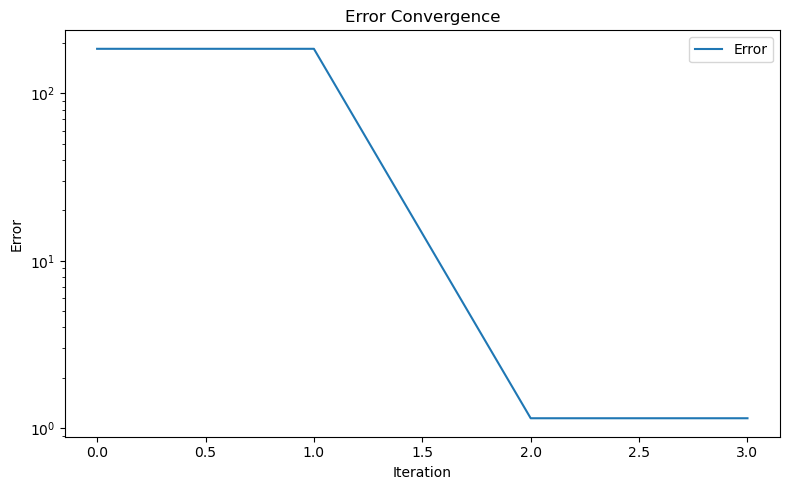

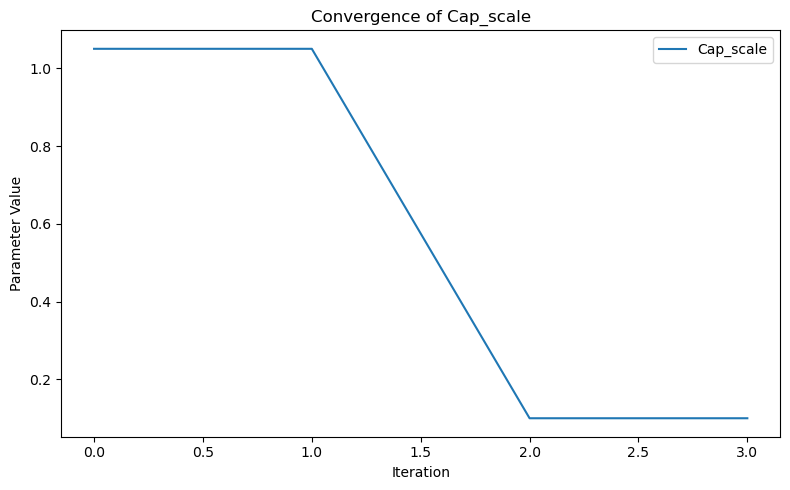

Optimization Results:
Final Error: 1.00e-10

Target Metrics:
R_in: 91.979 (target: 91.980)
Tau: 50.366 (target: 37.580)

Optimal Parameters:
Cap_scale: 0.100


In [5]:
import matplotlib.pyplot as plt
optimizer.plot_optimization_results(result)